In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yasserhessein/gender-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'gender-dataset' dataset.
Path to dataset files: /kaggle/input/gender-dataset


# Importing Libraries

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
os.listdir(path)

['Dataset']

In [6]:
path = os.path.join(path,"Dataset")

In [7]:
os.listdir(path)

['Validation', 'Test', 'Train']

In [8]:
train_path = os.path.join(path,"Train")
test_path = os.path.join(path,"Test")
val_path = os.path.join(path,"Validation")

# Dataset Loading

In [9]:
def load_dataset(dataset_path, max_per_class=50000, img_size=128):
    images = []
    labels = []

    print(f"Exploring dataset at: {dataset_path}")
    print(f"Contents: {os.listdir(dataset_path)}")

    folders = os.listdir(dataset_path)
    male_folder = [f for f in folders if f == "Male"][0]
    female_folder = [f for f in folders if f == "Female"][0]

    male_path = os.path.join(dataset_path, male_folder)
    male_images = [f for f in os.listdir(male_path) if f.endswith(('.jpg', '.jpeg'))]
    male_images = male_images[:max_per_class]

    print(f"\nLoading {len(male_images)} male images...")
    for img_name in tqdm(male_images):
        try:
            img_path = os.path.join(male_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (img_size, img_size))
            images.append(img)
            labels.append(1)  # Labelling 1 for male
        except Exception as e:
            continue

    female_path = os.path.join(dataset_path, female_folder)
    female_images = [f for f in os.listdir(female_path) if f.endswith(('.jpg', '.jpeg'))]
    female_images = female_images[:max_per_class]

    print(f"Loading {len(female_images)} female images...")
    for img_name in tqdm(female_images):
        try:
            img_path = os.path.join(female_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (img_size, img_size))
            images.append(img)
            labels.append(0)  # Labelling 0 for female
        except Exception as e:
            continue

    images = np.array(images, dtype='float32') / 255.0  # Normalization
    labels = np.array(labels)

    print(f"\nTotal images loaded: {len(images)}")
    print(f"Image shape: {images[0].shape}")
    print(f"Female: {np.sum(labels == 0)}, Male: {np.sum(labels == 1)}")

    return images, labels

In [10]:
X_train, y_train = load_dataset(train_path, 10000, 128)

Exploring dataset at: /kaggle/input/gender-dataset/Dataset/Train
Contents: ['Female', 'Male']

Loading 10000 male images...


100%|██████████| 10000/10000 [00:45<00:00, 219.19it/s]


Loading 10000 female images...


100%|██████████| 10000/10000 [00:45<00:00, 218.20it/s]



Total images loaded: 20000
Image shape: (128, 128, 3)
Female: 10000, Male: 10000


In [11]:
X_test, y_test = load_dataset(test_path, 2000, 128)

Exploring dataset at: /kaggle/input/gender-dataset/Dataset/Test
Contents: ['Female', 'Male']

Loading 2000 male images...


100%|██████████| 2000/2000 [00:09<00:00, 201.71it/s]


Loading 2000 female images...


100%|██████████| 2000/2000 [00:09<00:00, 209.44it/s]



Total images loaded: 4000
Image shape: (128, 128, 3)
Female: 2000, Male: 2000


In [12]:
X_val, y_val = load_dataset(val_path, 2000, 128)

Exploring dataset at: /kaggle/input/gender-dataset/Dataset/Validation
Contents: ['Female', 'Male']

Loading 2000 male images...


100%|██████████| 2000/2000 [00:10<00:00, 194.08it/s]


Loading 2000 female images...


100%|██████████| 2000/2000 [00:09<00:00, 210.63it/s]



Total images loaded: 4000
Image shape: (128, 128, 3)
Female: 2000, Male: 2000


# Visualizing Data

In [16]:
def visualize_samples(images, labels, n_samples=8):
    idx = np.random.choice(len(images), size=n_samples, replace=False)
    plt.figure(figsize=(15, 4))
    for i,index in enumerate(idx):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[index])
        plt.title(f"{'Male' if labels[index] == 1 else 'Female'}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Visualising training data...


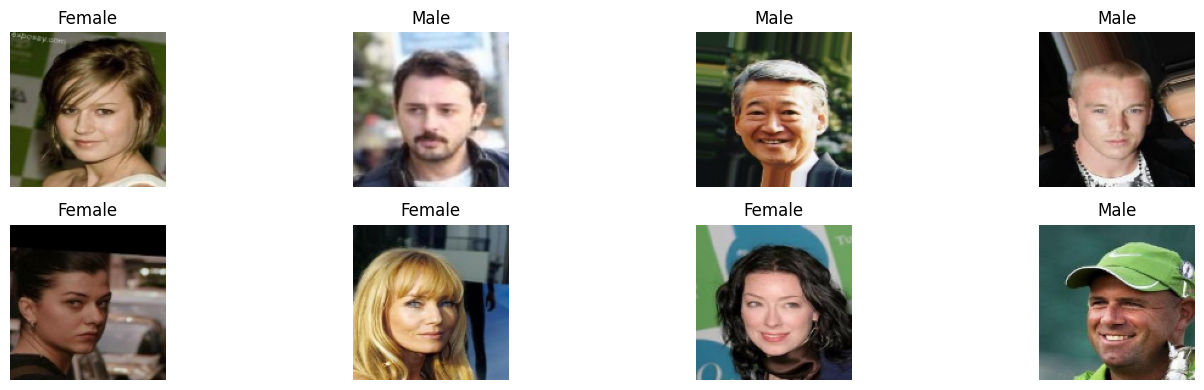

In [17]:
print("Visualising training data...")
visualize_samples(X_train, y_train)

# Data Augmentation

In [18]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest')

In [19]:
datagen.fit(X_train)

# Model Architecture

In [20]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), padding='same', input_shape=(128,128,3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(256, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.GlobalAveragePooling2D(), # to reduce overfitting

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(1, activation='sigmoid')])

In [21]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 423,873 (1.62 MB)

 Trainable params: 422,657 (1.61 MB)

 Non-trainable params: 1,216 (4.75 KB)

# Callbacks for Training

In [23]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1)

In [24]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1)

In [25]:
checkpoint = ModelCheckpoint(
    'best_gender_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1)

In [26]:
callbacks = [early_stop, reduce_lr, checkpoint]

# Model Training

In [27]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    steps_per_epoch=len(X_train) // 32,
    epochs=30,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1)

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.6358 - loss: 0.6892
Epoch 1: val_accuracy improved from -inf to 0.53450, saving model to best_gender_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 99s 137ms/step - accuracy: 0.6359 - loss: 0.6891 - val_accuracy: 0.5345 - val_loss: 1.2781 - learning_rate: 0.0010
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.7743 - loss: 0.4799
Epoch 2: val_accuracy did not improve from 0.53450
625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 133ms/step - accuracy: 0.7743 - loss: 0.4799 - val_accuracy: 0.5260 - val_loss: 1.5115 - learning_rate: 0.0010
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.8146 - loss: 0.4072
Epoch 3: val_accuracy improved from 0.53450 to 0.62300, saving model to best_gender_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 131ms/step - accuracy: 0.8146 - loss: 0.4072 - val_accuracy: 0.6230 - val_loss: 1.0627 - learning_rate: 0.0010
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8501 - loss: 0.3435
Epoch 4: val_accuracy improved from 0.62300 to 0.86325, saving model to best_gender_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 132ms/step - accuracy: 0.8501 - loss: 0.3435 - val_accuracy: 0.8633 - val_loss: 0.3104 - learning_rate: 0.0010
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8848 - loss: 0.2757
Epoch 5: val_accuracy did not improve from 0.86325
625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 133ms/step - accuracy: 0.8848 - loss: 0.2757 - val_accuracy: 0.8418 - val_loss: 0.4058 - learning_rate: 0.0010
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8965 - loss: 0.2461
Epoch 6: val_accuracy did not improve from 0.86325
625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 132ms/step - accuracy: 0.8965 - loss: 0.2461 - val_accuracy: 0.6665 - val_loss: 0.9576 - learning_rate: 0.0010
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9076 - loss: 0.2237
Epoch 7: val_accuracy improved from 0.86325 to 0.91100, saving model to best_gender_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 130ms/step - accuracy: 0.9076 - loss: 0.2237 - val_accuracy: 0.9110 - val_loss: 0.2192 - learning_rate: 0.0010
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9098 - loss: 0.2150
Epoch 8: val_accuracy did not improve from 0.91100
625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 133ms/step - accuracy: 0.9098 - loss: 0.2150 - val_accuracy: 0.9018 - val_loss: 0.2403 - learning_rate: 0.0010
Epoch 9/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9216 - loss: 0.2028
Epoch 9: val_accuracy improved from 0.91100 to 0.94175, saving model to best_gender_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 133ms/step - accuracy: 0.9216 - loss: 0.2028 - val_accuracy: 0.9417 - val_loss: 0.1515 - learning_rate: 0.0010
Epoch 10/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9248 - loss: 0.1867
Epoch 10: val_accuracy did not improve from 0.94175
625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 132ms/step - accuracy: 0.9248 - loss: 0.1867 - val_accuracy: 0.9398 - val_loss: 0.1634 - learning_rate: 0.0010
Epoch 11/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9236 - loss: 0.1941
Epoch 11: val_accuracy did not improve from 0.94175
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 129ms/step - accuracy: 0.9236 - loss: 0.1941 - val_accuracy: 0.9247 - val_loss: 0.1814 - learning_rate: 0.0010
Epoch 12/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9282 - loss: 0.1807
Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: val_accuracy did not improve from 0.94175
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 131ms/step - accuracy: 0.9282 - lo

625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 130ms/step - accuracy: 0.9402 - loss: 0.1517 - val_accuracy: 0.9510 - val_loss: 0.1275 - learning_rate: 5.0000e-04
Epoch 15/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9377 - loss: 0.1603
Epoch 15: val_accuracy did not improve from 0.95100
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 132ms/step - accuracy: 0.9377 - loss: 0.1603 - val_accuracy: 0.9205 - val_loss: 0.1915 - learning_rate: 5.0000e-04
Epoch 16/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9419 - loss: 0.1503
Epoch 16: val_accuracy did not improve from 0.95100
625/625 ━━━━━━━━━━━━━━━━━━━━ 84s 134ms/step - accuracy: 0.9419 - loss: 0.1503 - val_accuracy: 0.9463 - val_loss: 0.1324 - learning_rate: 5.0000e-04
Epoch 17/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9409 - loss: 0.1523
Epoch 17: val_accuracy did not improve from 0.95100
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 130ms/step - accuracy: 0.9409 - loss: 0.1523 - val_accuracy: 0.9505 - val_loss: 0.1274 - learning_ra

625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 133ms/step - accuracy: 0.9423 - loss: 0.1451 - val_accuracy: 0.9523 - val_loss: 0.1380 - learning_rate: 5.0000e-04
Epoch 19/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9487 - loss: 0.1324
Epoch 19: val_accuracy did not improve from 0.95225
625/625 ━━━━━━━━━━━━━━━━━━━━ 85s 136ms/step - accuracy: 0.9487 - loss: 0.1324 - val_accuracy: 0.9043 - val_loss: 0.2469 - learning_rate: 5.0000e-04
Epoch 20/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9497 - loss: 0.1345
Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 20: val_accuracy did not improve from 0.95225
625/625 ━━━━━━━━━━━━━━━━━━━━ 86s 138ms/step - accuracy: 0.9497 - loss: 0.1345 - val_accuracy: 0.9340 - val_loss: 0.1986 - learning_rate: 5.0000e-04
Epoch 21/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9469 - loss: 0.1345
Epoch 21: val_accuracy did not improve from 0.95225
625/625 ━━━━━━━━━━━━━━━━━━━━ 84s 135ms/step - accuracy:

625/625 ━━━━━━━━━━━━━━━━━━━━ 85s 136ms/step - accuracy: 0.9498 - loss: 0.1315 - val_accuracy: 0.9557 - val_loss: 0.1149 - learning_rate: 2.5000e-04
Epoch 23/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9489 - loss: 0.1280
Epoch 23: val_accuracy improved from 0.95575 to 0.95975, saving model to best_gender_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 84s 135ms/step - accuracy: 0.9489 - loss: 0.1280 - val_accuracy: 0.9597 - val_loss: 0.1076 - learning_rate: 2.5000e-04
Epoch 24/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9513 - loss: 0.1240
Epoch 24: val_accuracy improved from 0.95975 to 0.96150, saving model to best_gender_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 84s 135ms/step - accuracy: 0.9513 - loss: 0.1240 - val_accuracy: 0.9615 - val_loss: 0.0921 - learning_rate: 2.5000e-04
Epoch 25/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9539 - loss: 0.1193
Epoch 25: val_accuracy improved from 0.96150 to 0.96300, saving model to best_gender_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 132ms/step - accuracy: 0.9539 - loss: 0.1193 - val_accuracy: 0.9630 - val_loss: 0.1012 - learning_rate: 2.5000e-04
Epoch 26/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9523 - loss: 0.1192
Epoch 26: val_accuracy did not improve from 0.96300
625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 133ms/step - accuracy: 0.9523 - loss: 0.1192 - val_accuracy: 0.9383 - val_loss: 0.1546 - learning_rate: 2.5000e-04
Epoch 27/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9526 - loss: 0.1192
Epoch 27: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 27: val_accuracy did not improve from 0.96300
625/625 ━━━━━━━━━━━━━━━━━━━━ 86s 138ms/step - accuracy: 0.9526 - loss: 0.1192 - val_accuracy: 0.9595 - val_loss: 0.1013 - learning_rate: 2.5000e-04
Epoch 28/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9569 - loss: 0.1086
Epoch 28: val_accuracy did not improve from 0.96300
625/625 ━━━━━━━━━━━━━━━━━━━━ 165s 175ms/step - accuracy

# Training History Visualisation

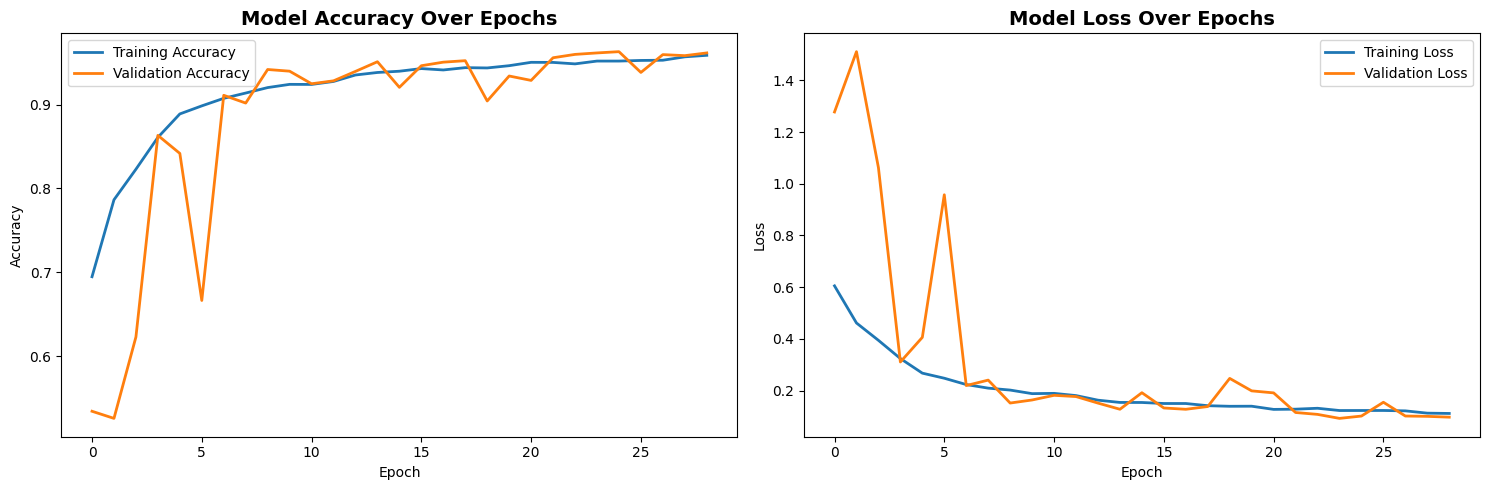

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()

# Model Evaluation

In [29]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

Test Accuracy: 97.10%
Test Loss: 0.0765


In [30]:
y_pred_probs = model.predict(X_test, verbose=0)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

In [32]:
print(classification_report(y_test, y_pred, target_names=['Female', 'Male']))

              precision    recall  f1-score   support

      Female       0.98      0.96      0.97      2000
        Male       0.96      0.98      0.97      2000

    accuracy                           0.97      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.97      0.97      0.97      4000



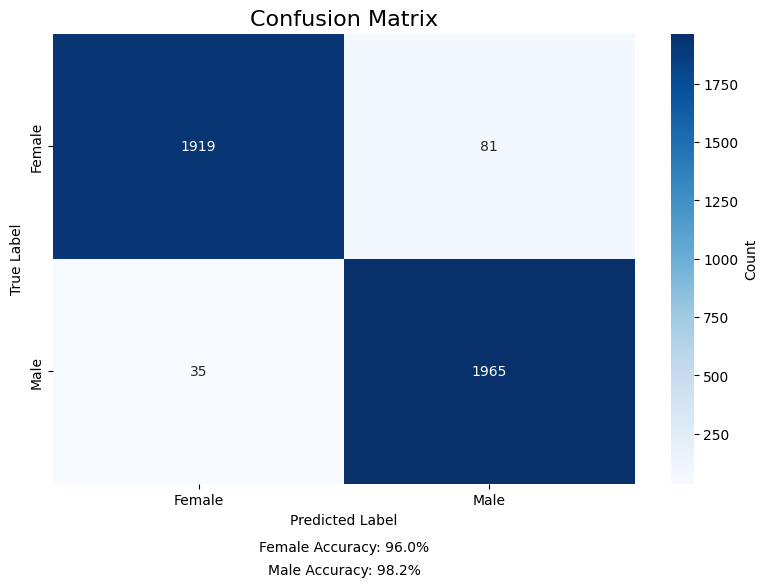

In [33]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'], cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

accuracy_female = cm[0, 0] / (cm[0, 0] + cm[0, 1]) * 100
accuracy_male = cm[1, 1] / (cm[1, 0] + cm[1, 1]) * 100

plt.text(0.5, -0.15, f'Female Accuracy: {accuracy_female:.1f}%', ha='center', transform=plt.gca().transAxes)
plt.text(0.5, -0.2, f'Male Accuracy: {accuracy_male:.1f}%', ha='center', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

# Prediction Visualization

In [34]:
def visualize_predictions(images, true_labels, pred_probs, n_samples=16):
    pred_labels = (pred_probs > 0.5).astype(int).flatten()
    correct_mask = (pred_labels == true_labels)

    # Trying to get equal correct and incorrect samples
    n_correct = n_samples // 2
    n_incorrect = n_samples - n_correct

    correct_indices = np.where(correct_mask)[0]
    incorrect_indices = np.where(~correct_mask)[0]

    selected_correct = np.random.choice(correct_indices, min(n_correct, len(correct_indices)), replace=False)
    selected_incorrect = np.random.choice(incorrect_indices, min(n_incorrect, len(incorrect_indices)), replace=False)

    selected_indices = np.concatenate([selected_correct, selected_incorrect])
    np.random.shuffle(selected_indices)

    plt.figure(figsize=(20, 10))
    for i, idx in enumerate(selected_indices[:n_samples]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[idx])
        true_label = 'Male' if true_labels[idx] == 1 else 'Female'
        pred_label = 'Male' if pred_labels[idx] == 1 else 'Female'
        confidence = pred_probs[idx][0] if pred_labels[idx] == 1 else 1 - pred_probs[idx][0]

        color = 'green' if pred_labels[idx] == true_labels[idx] else 'red'

        plt.title(f"True: {true_label}\nPred: {pred_label} ({confidence*100:.1f}%)", color=color, fontweight='bold')
        plt.axis('off')

    plt.suptitle('Model Predictions (Green=Correct, Red=Incorrect)', fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

Visualization of predictions on test set:


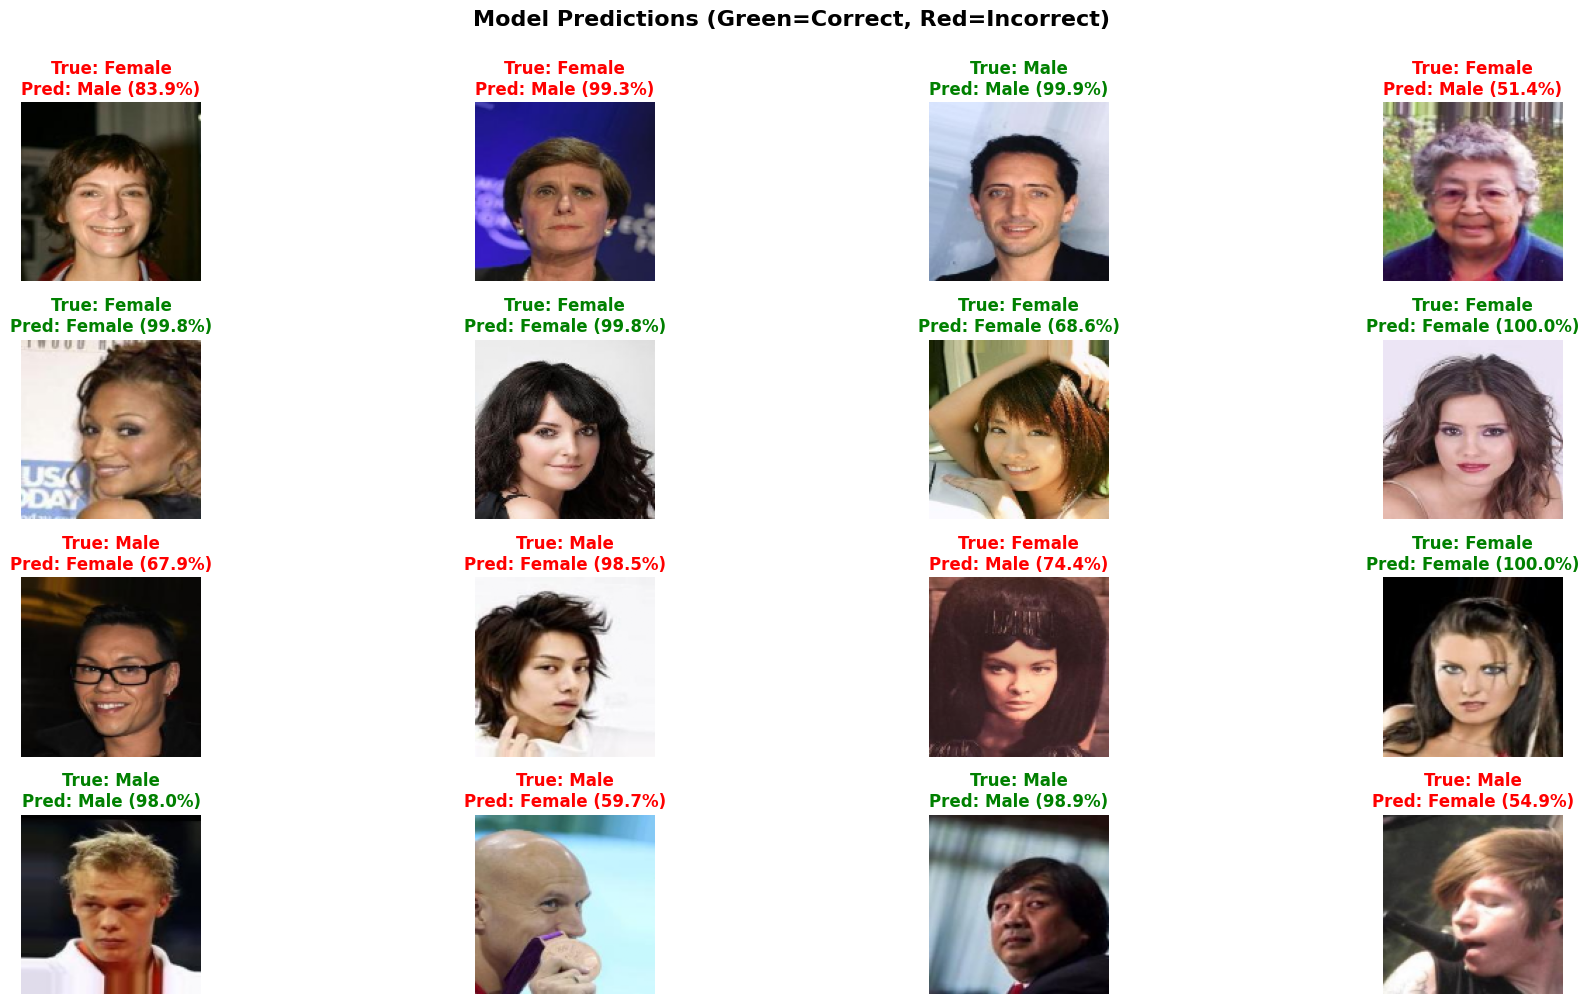

In [36]:
print("Visualization of predictions on test set:")
visualize_predictions(X_test, y_test, y_pred_probs, n_samples=16)

# Model Saving & Results

In [37]:
model.save('gender_detection_final.h5')

In [38]:
print(f"Best Validation Accuracy: {max(history.history['val_accuracy'])*100:.2f}%")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

Best Validation Accuracy: 96.30%
Test Accuracy: 97.10%


# Prediction for New Images

In [49]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

def predict_gender(image_path, model):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=5)

    if len(faces) == 0:
        print("No faces detected.")
        return None

    for (x, y, w, h) in faces:
        face_img = img_rgb[y:y+h, x:x+w]
        face_resized = cv2.resize(face_img, (128, 128))
        face_norm = face_resized / 255.0
        face_batch = np.expand_dims(face_norm, axis=0)

        pred_prob = model.predict(face_batch, verbose=0)[0][0]

        if pred_prob > 0.5:
            gender = "Male"
            confidence = pred_prob * 100
            color = (0, 255, 0) # Green for Male
        else:
            gender = "Female"
            confidence = (1 - pred_prob) * 100
            color = (255, 0, 0) # Red for Female

        cv2.rectangle(img_rgb, (x, y), (x+w, y+h), color, 3)
        cv2.putText(img_rgb, f"{gender} ({confidence:.1f}%)",
                    (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

    plt.figure(figsize=(4, 4))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.show()

# Prediction Examples

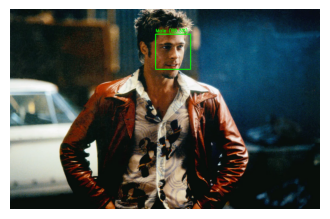

In [71]:
predict_gender("/content/M8DFICL_FE002.webp", model)

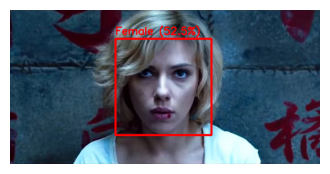

In [69]:
predict_gender("/content/Brody-Lucy.webp", model)

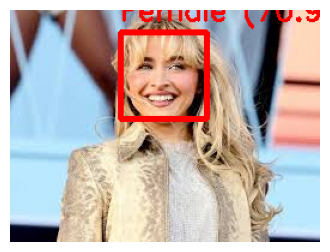

In [76]:
predict_gender("/content/download (9).jpeg", model)

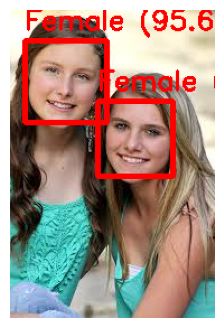

In [84]:
predict_gender("/content/images (10).jpeg", model)

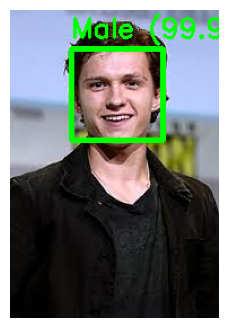

In [78]:
predict_gender("/content/download (11).jpeg", model)

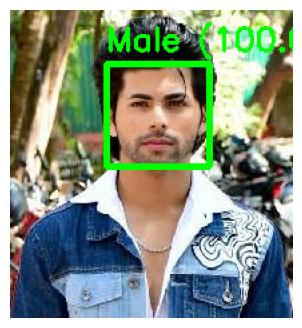

In [79]:
predict_gender("/content/download (12).jpeg", model)

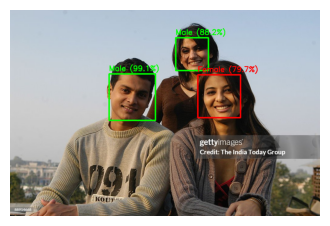

In [88]:
predict_gender("/content/download (15).jpg", model)

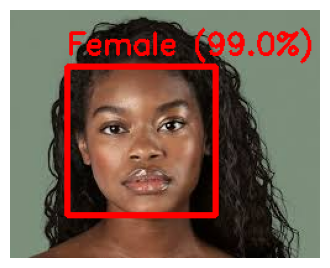

In [50]:
predict_gender("/content/download.jpeg", model)

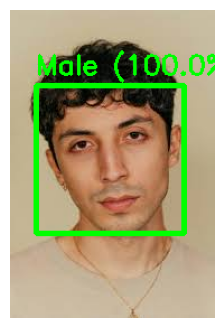

In [52]:
predict_gender("/content/download (1).jpeg", model)

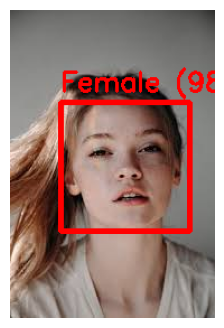

In [54]:
predict_gender("/content/download (2).jpeg", model)

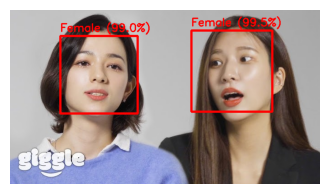

In [90]:
predict_gender("/content/hq720.jpg", model)

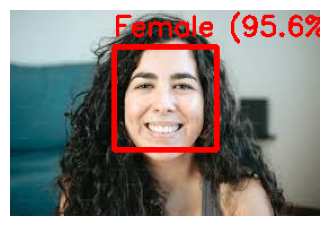

In [55]:
predict_gender("/content/download (3).jpeg", model)

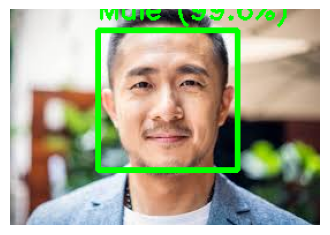

In [61]:
predict_gender("/content/images (3).jpeg", model)

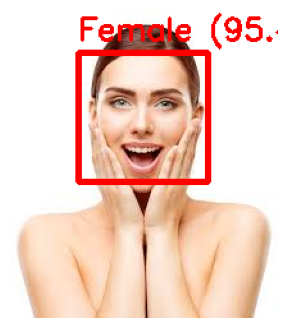

In [58]:
predict_gender("/content/images (1).jpeg", model)

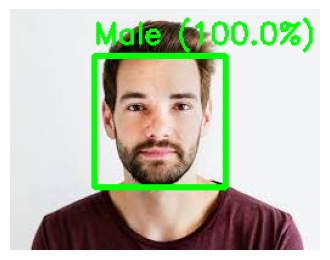

In [62]:
predict_gender("/content/images (4).jpeg", model)

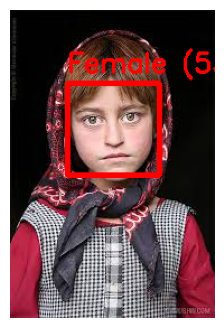

In [63]:
predict_gender("/content/images (5).jpeg", model)

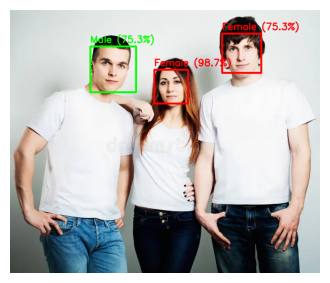

In [89]:
predict_gender("/content/download (16).webp", model)

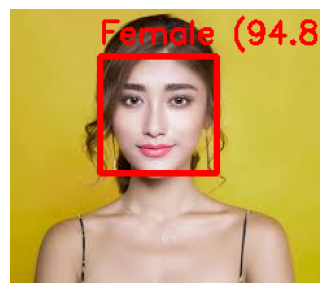

In [64]:
predict_gender("/content/images (6).jpeg", model)

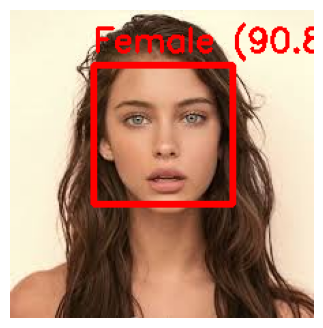

In [65]:
predict_gender("/content/images (7).jpeg", model)

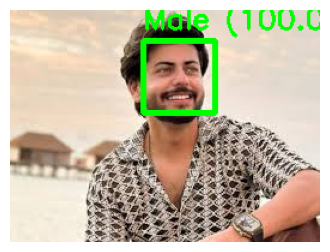

In [80]:
predict_gender("/content/download (13).jpeg", model)

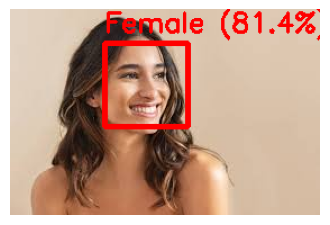

In [66]:
predict_gender("/content/images (8).jpeg", model)

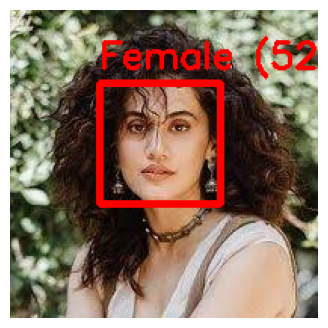

In [81]:
predict_gender("/content/download (14).jpeg", model)